## Notes on first-pass analysis

Need to check the quality of the integration.

Looks like there is a T-cell doublet cluster? Cluster 10?

In [1]:
# basic python packages
import numpy as np
import pandas as pd
import os
import sys 

# plotting
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# singlecell packages
import scanpy as sc
import anndata
import harmonypy as hm
import cellanova as cnova

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

In [2]:
# load BigSur
bigsur_dir = '/home/groups/singlecell/smorabito/bin/BigSur/'
sys.path.append(bigsur_dir) 

from BigSur.feature_selection import mcfano_feature_selection as mcfano

In [3]:
# helper func
def append_percent_expressed(adata, marker_genes_df, group_key, expression_thresh):
    """
    Append percentage of cells expressing each gene in the cluster of interest
    (pct_in_group) and in all other clusters (pct_out_group) to the marker gene DataFrame.

    Parameters:
    - adata: AnnData object.
    - marker_genes_df: DataFrame of marker genes generated by sc.tl.rank_genes_groups.
    - group_key: Column in adata.obs containing cluster annotations (e.g., 'leiden').

    Returns:
    - Updated marker gene DataFrame with pct_in_group and pct_out_group columns.
    """
    # Binary matrix indicating whether each gene is expressed in each cell
    binary_matrix = adata.X > expression_thresh  # Adjust if data is log-transformed or sparse
    
    # Initialize new columns
    pct_in_group_list = []
    pct_out_group_list = []

    # Iterate over each cluster in the marker gene DataFrame
    unique_clusters = marker_genes_df["group"].unique()
    for cluster in unique_clusters:
        print(cluster)
        # Create a mask for the cluster of interest
        cluster_mask = adata.obs[group_key] == cluster

        # Calculate percentages
        pct_in_group = np.asarray(binary_matrix[cluster_mask, :].mean(axis=0)).flatten() * 100
        pct_out_group = np.asarray(binary_matrix[~cluster_mask, :].mean(axis=0)).flatten() * 100

        # Map percentages back to marker genes
        for gene in marker_genes_df[marker_genes_df["group"] == cluster]["names"]:
            gene_idx = adata.var_names.get_loc(gene)
            pct_in_group_list.append(pct_in_group[gene_idx])
            pct_out_group_list.append(pct_out_group[gene_idx])

    # Add the calculated percentages to the DataFrame
    marker_genes_df["pct_in_group"] = pct_in_group_list
    marker_genes_df["pct_out_group"] = pct_out_group_list

    return marker_genes_df



In [4]:
# set the project directory 
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/clustering/Bcells')
data_dir = 'data/'
fig_dir = 'figures/'

In [5]:
# re-load the final dataset
cur_celltype = 'Bcells'
adata = sc.read_h5ad('{}/{}_integrated.h5ad'.format(data_dir, cur_celltype))

In [5]:
# read the unprocessed dataset
adata = sc.read_h5ad('/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_Chen2024_merged_unprocessed_171224.h5ad')


## Subset the B cell lineage

In [6]:
adata.obs.cell_type.value_counts()

cell_type
T cells       153360
T             118957
Epi            78975
Epithelial     62126
B              47678
Myeloid        31850
Stromal        24789
NK cells       20520
Mye            11606
B cells        11207
ILC             5236
Plasma          4875
Mast cells       990
Name: count, dtype: int64

In [7]:
cur_celltype = 'Bcells' 

# get the B cell lineage
adata = adata[adata.obs.cell_type.isin(['B', 'B cells', 'Plasma'])].copy()
adata.shape

(63760, 36017)

## Run Feature Selection (BigSur)

In [11]:
# create column for tissue + timepoint
adata.obs['Tissue_Timepoint'] = adata.obs.Tissue.astype(str) + "_" + adata.obs.Timepoint.astype(str)


In [12]:
group_col = 'Tissue_Timepoint'

# exclude replicates from the least represented groups for this step
group_list = adata.obs[group_col].unique()
group_list = [x for x in group_list if 'Subcutaneous' not in x]
group_list = [x for x in group_list if 'Implant' not in x]
group_list = [x for x in group_list if 'Peritoneum' not in x]

var_dict = {}

for cur_group in group_list:
    print(cur_group)
    cur_adata = adata[adata.obs[group_col] == cur_group].copy()

    sc.pp.filter_genes(cur_adata, min_cells=3)
    mcfano(cur_adata, layer='counts')

    var_dict[cur_group] = cur_adata.var.copy()
    

Primary_1
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.8
Primary_2
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.75
Primary_3
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.8
Primary_4
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.7
Liver met_1
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.8
Liver met_2
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.8
Lung met_1
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.8
Lung met_2
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv

In [13]:
# count how many times each gene appears 
signif_list = []
for cur_group, cur_var in var_dict.items():
    print(cur_group)
    mc_cutoff = np.quantile(cur_var['mc_Fano'], q=0.9)
    tmp = cur_var.loc[(cur_var.p_value <= 0.05) & (cur_var.mc_Fano >= mc_cutoff)]
    tmp['group'] = cur_group 
    signif_list.append(tmp)
    print(tmp.shape)

# Exclude the genes that were only considered highly variable in 2 or fewer groups
combined = pd.concat(signif_list)
var_genes = combined.gene_ids.value_counts()[combined.gene_ids.value_counts() > 2].index.to_list()
adata.var['highly_variable'] = adata.var.index.isin(var_genes)


Primary_1
(1610, 27)
Primary_2
(1775, 27)
Primary_3
(1446, 27)
Primary_4
(1227, 27)
Liver met_1
(1557, 27)
Liver met_2
(1643, 27)
Lung met_1
(1718, 27)
Lung met_2
(1780, 27)
Liver met_3
(1470, 27)
Lymph node_1
(1368, 27)
Lymph node_2
(1311, 27)
2046


/scratch_tmp/34004265/ipykernel_245948/212066303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['group'] = cur_group
/scratch_tmp/34004265/ipykernel_245948/212066303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['group'] = cur_group
/scratch_tmp/34004265/ipykernel_245948/212066303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [14]:
print(len(var_genes))

2046


## Integration w/ CellANOVA

In [15]:
# re-order (IDK if this has any effect on the downstream result, but they do it in the CellANOVA code so...)
integrate_key = "Replicate"
adata = adata[adata.obs.sort_values(integrate_key).index]

In [18]:
# normalize expression matrix
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()

# save the dataset with the full expression matrix so we can use it later
adata_full = adata.copy()

# subset by HVGs
adata = adata[:,adata.var.highly_variable].copy()

# scale expression matrix
sc.pp.scale(adata)
adata.layers['scale'] = adata.X.copy()

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
#-------------------------------------------------------------#
# CellANOVA step 1: Define the pool of controls
# 
# we use a separate pool of controls for each tissue (i.e. met)
#-------------------------------------------------------------#

group_col = 'Tissue'
group_list = adata.obs[group_col].unique()

control_dict = {
    group : adata.obs[
        (adata.obs[group_col] == group) & 
        (adata.obs.Timepoint == 1)
    ].Replicate.unique().to_list() for group in group_list 
}

# exclude the CD45 negative samples, and exclude the groups w/ only 1 control 
for group in group_list:
    value = control_dict[group]
    control_dict[group] = [v for v in value if "CD45neg" not in v]
    if len(control_dict[group]) == 1: del control_dict[group]
    

/scratch_tmp/34004265/ipykernel_245948/783058548.py:11: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  group : adata.obs[


In [20]:
#-------------------------------------------------------------#
# CellANOVA Step 2: Calculate "Main Effects"
#-------------------------------------------------------------#

adata = cnova.model.calc_ME(
    adata,
    integrate_key='Replicate',
    k_harmony = 30
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
2025-01-15 17:12:48,998 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-15 17:13:02,332 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-15 17:13:02,845 - harmonypy - INFO - Iteration 1 of 30
2025-01-15 17:13:31,334 - harmonypy - INFO - Iteration 2 of 30
2025-01-15 17:13:59,410 - harmonypy - INFO - Iteration 3 of 30
2025-01-15 17:14:27,474 - harmonypy - INFO - Iteration 4 of 30
2025-01-15 17:14:55,510 - harmonypy - INFO - Iteration 5 of 30
2025-01-15 17:15:23,571 - harmonypy - INFO - Iteration 6 of 30
2025-01-15 17:15:47,394 - harmonypy - INFO - Iteration 7 of 30
2025-01-15 17:16:03,840 - harmonypy - INFO - Iteration 8 of 30
2025-01-15 17:16:19,347 - harmonypy - INFO - Iteration 9 of 30
2025-01-15 17:16:36,843 - harmonypy

In [21]:
#-------------------------------------------------------------#
# CellANOVA Step 3: Calculate Batch Effects (BE)
#-------------------------------------------------------------#

adata = cnova.model.calc_BE(
    adata,
    integrate_key = 'Replicate',
    control_dict = control_dict
)

In [22]:
#-------------------------------------------------------------#
# CellANOVA Step 4: Calculate Treatment Effect (TE)
#-------------------------------------------------------------#

adata = cnova.model.calc_TE(
    adata, 
    integrate_key='Replicate'
)

## Clustering

In [23]:
adata.X = adata.layers['denoised'].copy()

In [24]:
sc.tl.pca(adata)

sc.pp.neighbors(
    adata,
    n_neighbors=20, n_pcs=30, metric='cosine'
)

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
sc.tl.umap(adata, min_dist=0.35)

In [26]:

# clustering
res_list = [1,2,3]
for res in res_list:
    print(res)
    sc.tl.leiden(adata, resolution=res)
    adata.obs["leiden_{}".format(str(res))] = adata.obs.leiden.to_list()



1
2
3


## Save CellANOVA adata object, add info to the full adata 

Since we had to subset by HVGs to run CellANOVA, here we will save the intermediate anndata object that we used for the CellANOVA analysis and we will move the relevant data to the full anndata object

* CellANOVA PCA matrix
* CellANOVA UMAP
* Clusters

In [28]:
# write the CellANOVA intermediate file
adata.write("{}/{}_CellANOVA_HVGs.h5ad".format(data_dir, cur_celltype))

In [29]:
# copy the Harmony representation computed by CellANOVA:
adata_full.obsm['Cmat'] = adata.obsm['Cmat'].copy()

# copy the PCA matrix computed on the CellANOVA-corrected dataset 
adata_full.obsm['X_pca_CellANOVA'] = adata.obsm['X_pca'].copy()

# copy the UMAP computed from the CellANOVA-corrected dataset 
adata_full.obsm['X_umap'] = adata.obsm['X_umap'].copy()

# copy the whole .uns (hopefully won't cause any problems...?) 
adata_full.uns = adata.uns.copy()

# copy the clusters:
cluster_cols = [x for x in adata.obs.columns.to_list() if "leiden" in x]
for cur_cluster in cluster_cols:
    adata_full.obs[cur_cluster] = adata.obs[cur_cluster].copy()


In [30]:
# write the full integrated object
adata_full.write('{}/{}_integrated.h5ad'.format(data_dir, cur_celltype))

In [31]:
adata = adata_full.copy()
del adata_full

## Plot the clustering results

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

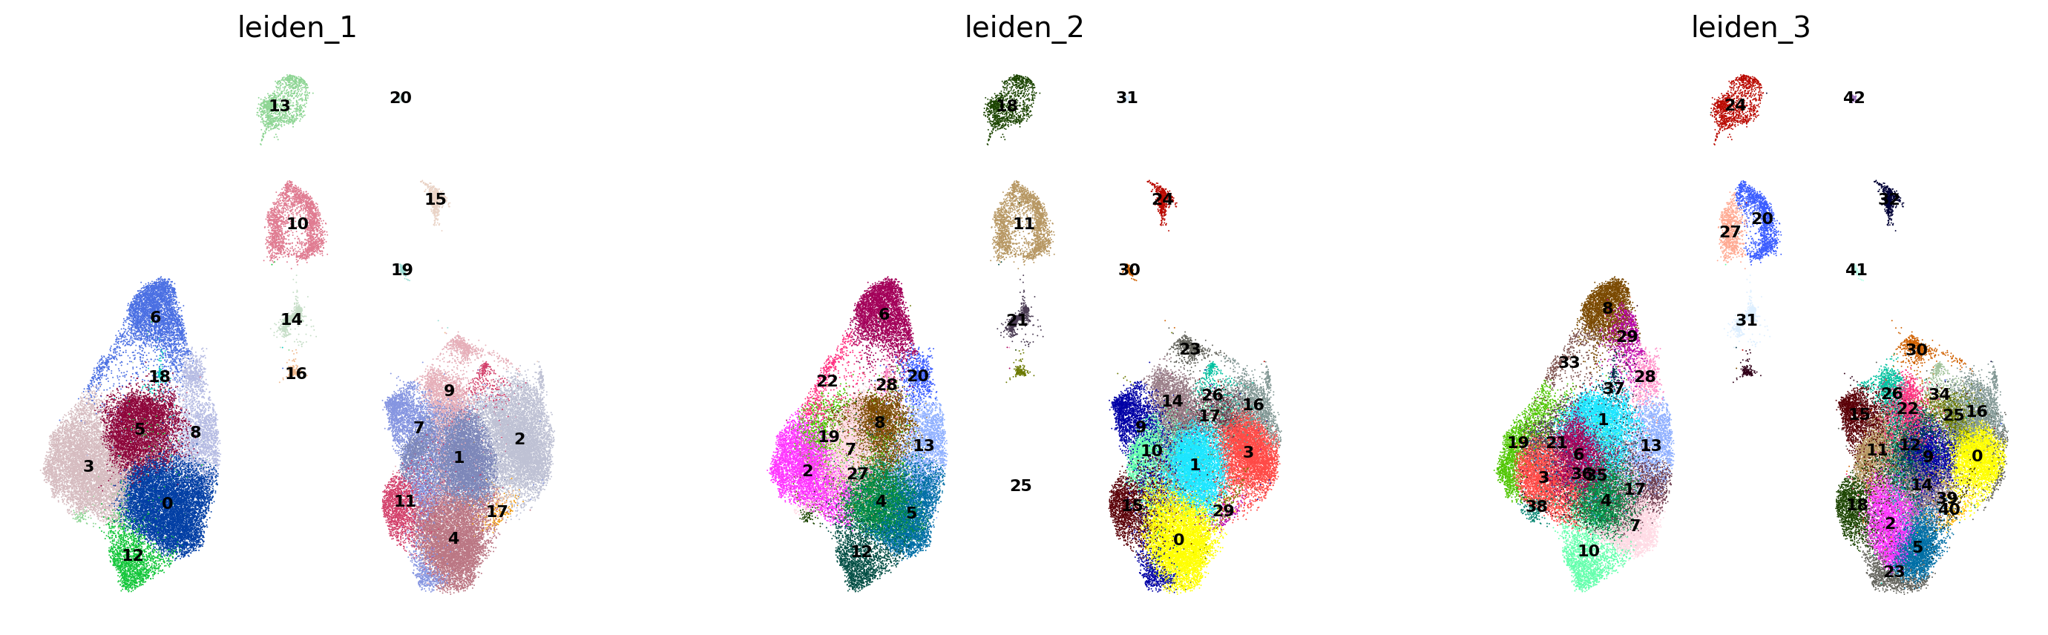

In [32]:
sc.settings.set_figure_params(dpi=100, dpi_save=250, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata,
    color = ['leiden_1', 'leiden_2', 'leiden_3'], 
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    ncols=3
)

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


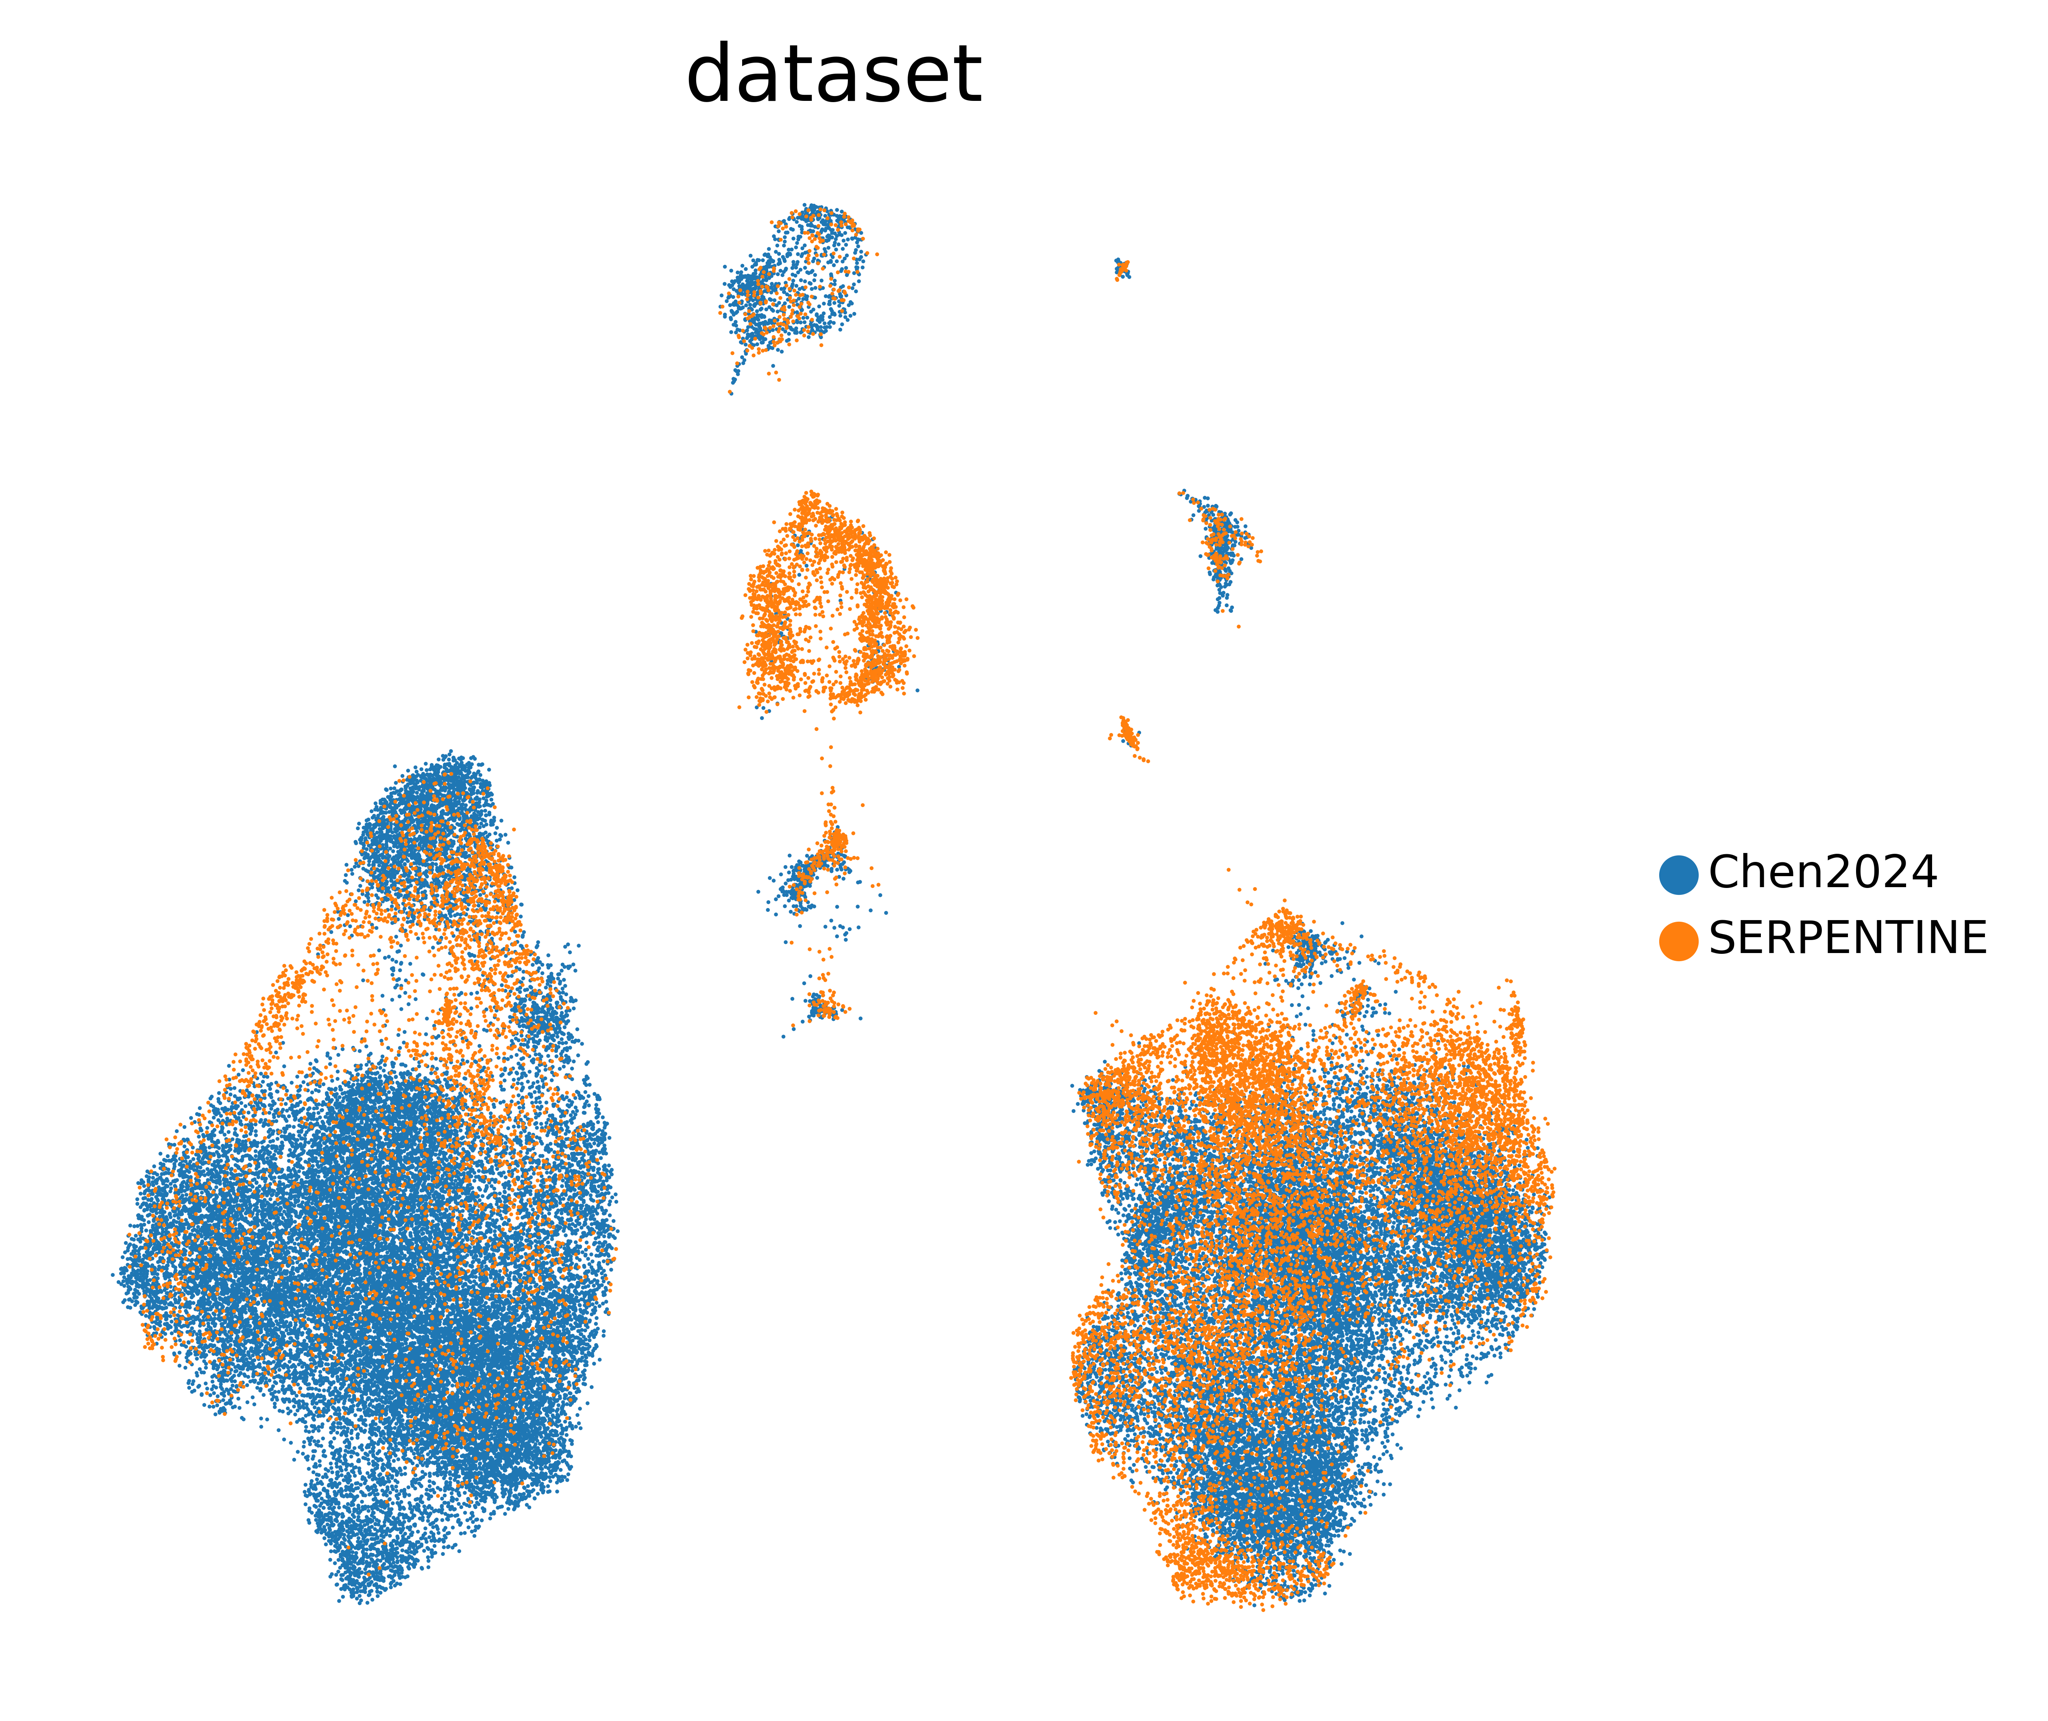

In [34]:
sc.settings.set_figure_params(dpi=500, dpi_save=250, figsize=(5,5), facecolor='white')

sc.pl.umap(
    adata,
    color = ['dataset'],
    legend_fontsize=8, 
    frameon = False,
    ncols=3
)

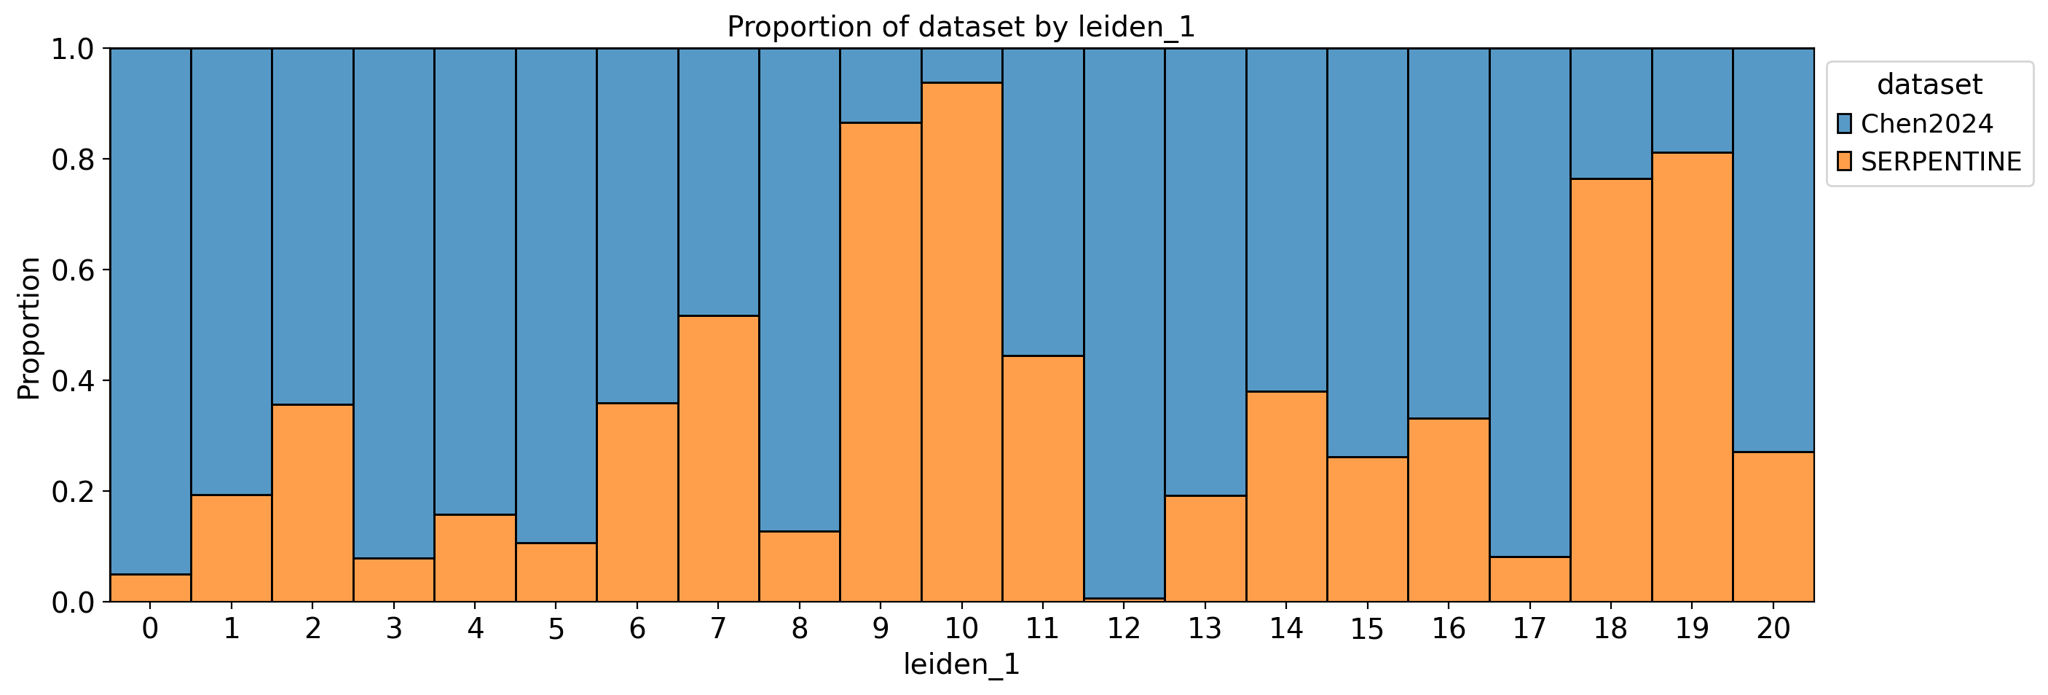

In [37]:
# stacked bar chart
sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

cur_clusters = 'leiden_1'
meta_var = 'dataset'

ax = sns.histplot(
    data = adata.obs,
    x = cur_clusters,
    hue = meta_var,
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Proportion of {} by {}'.format(meta_var, cur_clusters))
plt.grid(False)
plt.savefig(
    "{}/proportion_{}_{}_{}.pdf".format(fig_dir, cur_celltype, cur_clusters, meta_var), 
    format="pdf", bbox_inches="tight"
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


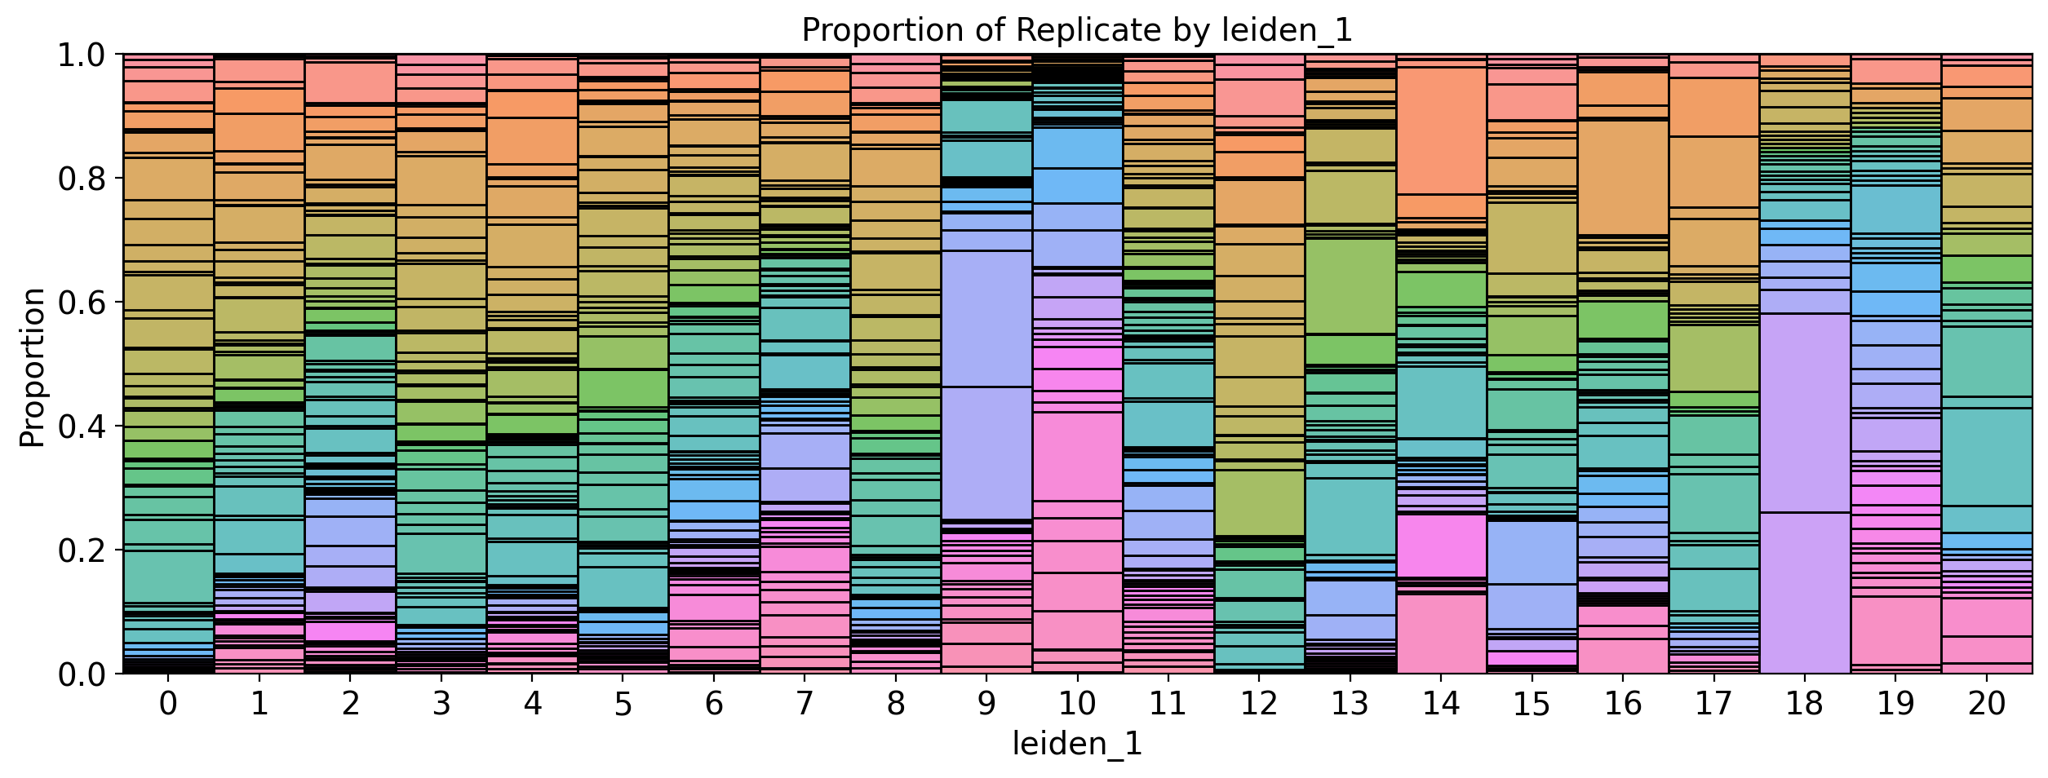

In [47]:
# stacked bar chart
sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

cur_clusters = 'leiden_1'
meta_var = 'Replicate'

ax = sns.histplot(
    data = adata.obs,
    x = cur_clusters,
    hue = meta_var,
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.legend().remove()
plt.title('Proportion of {} by {}'.format(meta_var, cur_clusters))
plt.grid(False)
plt.savefig(
    "{}/proportion_{}_{}_{}.pdf".format(fig_dir, cur_celltype, cur_clusters, meta_var), 
    format="pdf", bbox_inches="tight"
)


In [36]:
adata.obs.dataset.value_counts()

dataset
Chen2024      47678
SERPENTINE    16082
Name: count, dtype: int64

In [44]:
# # calculate dendrogram
sc.tl.dendrogram(adata, groupby='leiden_1', use_rep='X_pca_CellANOVA')

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


categories: 0, 1, 2, etc.
var_group_labels: Immune, CD4 + T, CD8+ T, etc.


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping pr

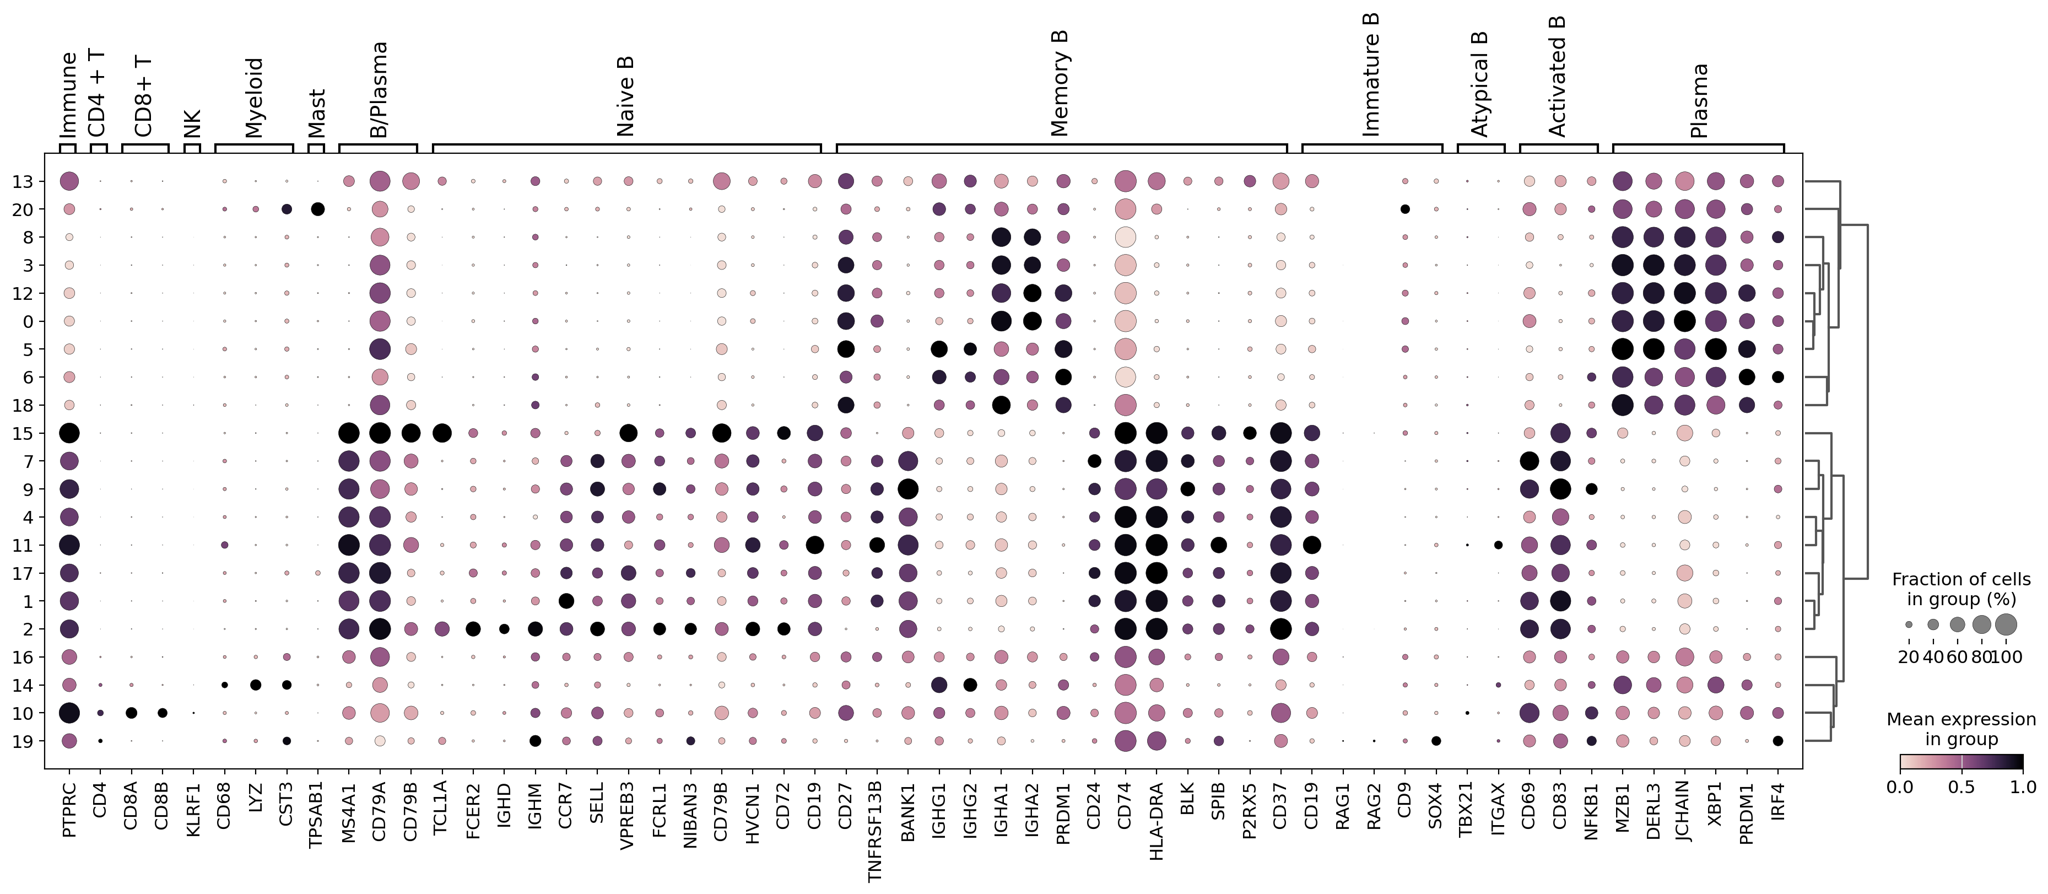

In [48]:

sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

marker_dict = {
    'Immune': ['PTPRC'],
    'CD4 + T': ['CD4'],
    'CD8+ T': ['CD8A', 'CD8B'],
    'NK': ['KLRF1'],
    'Myeloid': ['CD68', 'LYZ', 'CST3'],
    'Mast': ['TPSAB1'],
    'B/Plasma': ['MS4A1', 'CD79A', 'CD79B'],
    'Naive B' : [
        'TCL1A', 'FCER2', 'IGHD', 'IGHM', 'CCR7', 'SELL',  'VPREB3', 'FCRL1', 'NIBAN3', 'CD79B',
        'HVCN1', 'CD72', 'CD19'
    ],
    'Memory B' : ['CD27', 'TNFRSF13B', 'BANK1', 'IGHG1', 'IGHG2', 'IGHA1', 'IGHA2', 'PRDM1', 'CD24', 
                  'CD74', 'HLA-DRA', 'BLK', 'SPIB', 'P2RX5', 'CD37'],
    'Immature B': ['CD19', 'RAG1', 'RAG2', 'CD9', 'SOX4'],
    'Atypical B': ['TBX21', 'ITGAX'],
    'Activated B': ['CD69', 'CD83', 'NFKB1'],
    'Plasma': ['MZB1', 'DERL3', 'JCHAIN', 'XBP1', 'PRDM1', 'IRF4']
    
}

sc.pl.dotplot(
    adata, marker_dict, 'leiden_1',
    standard_scale='var', swap_axes=False,
    color_map=sns.cubehelix_palette(dark=0, light=.9, as_cmap=True),
    dendrogram=True
    #save="{}_selected_markers.pdf".format(cur_celltype),
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


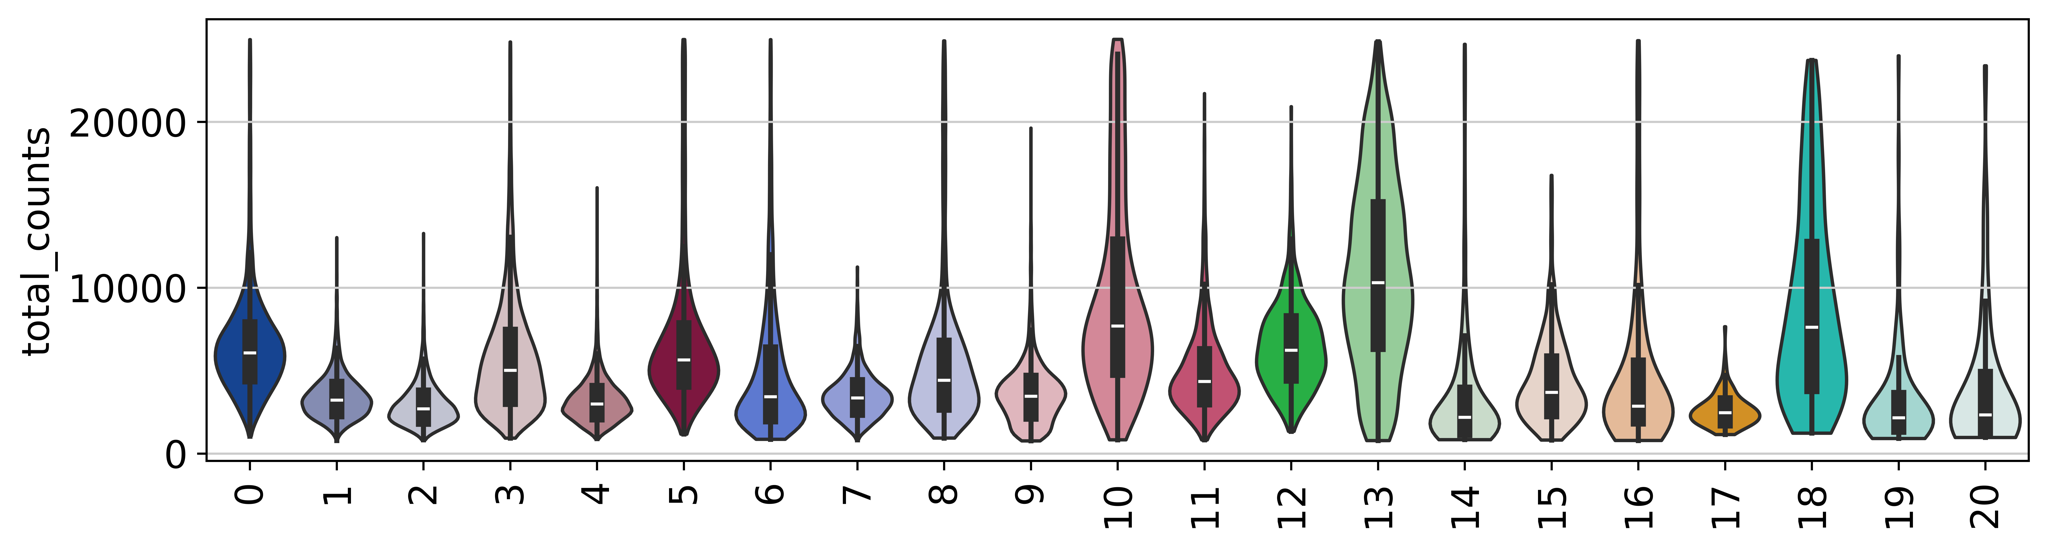

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


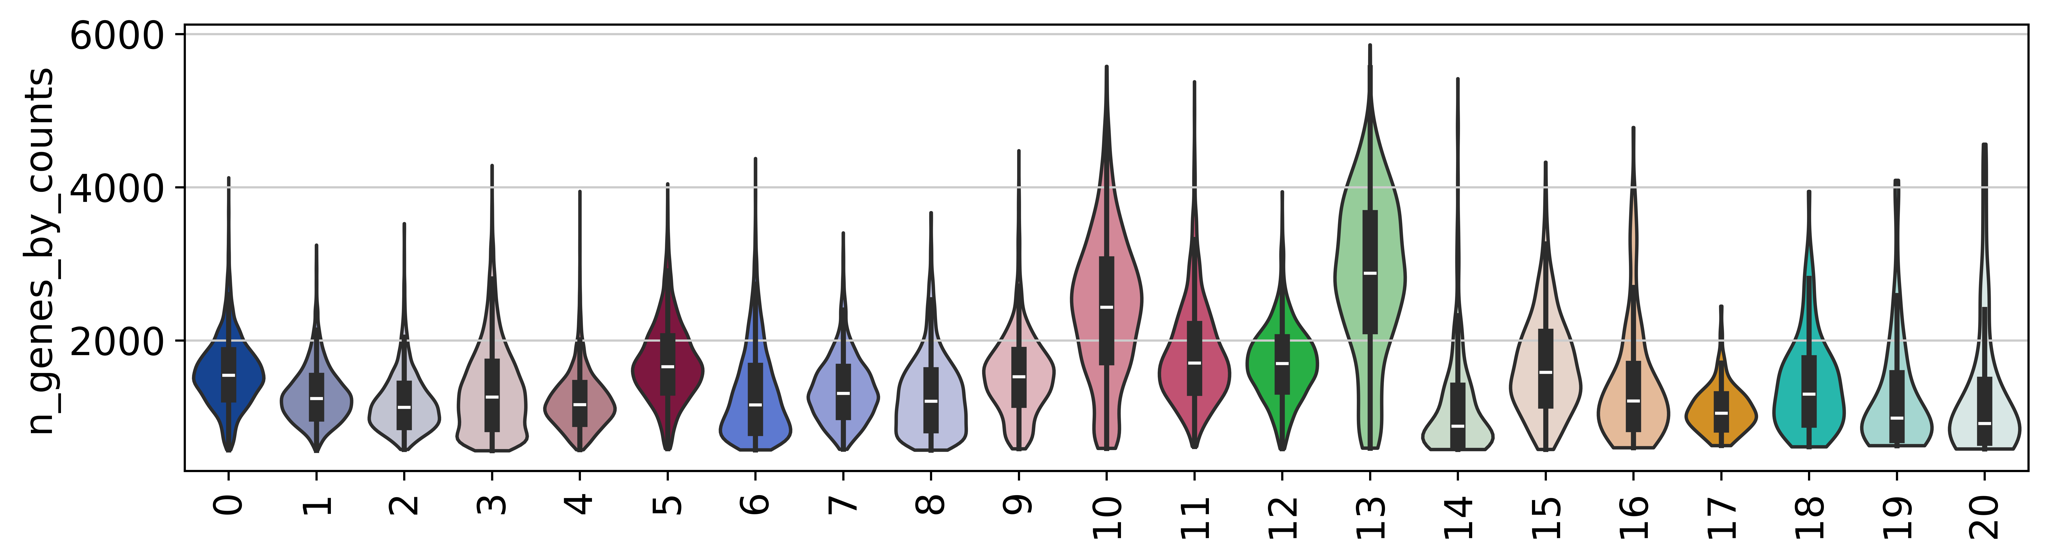

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


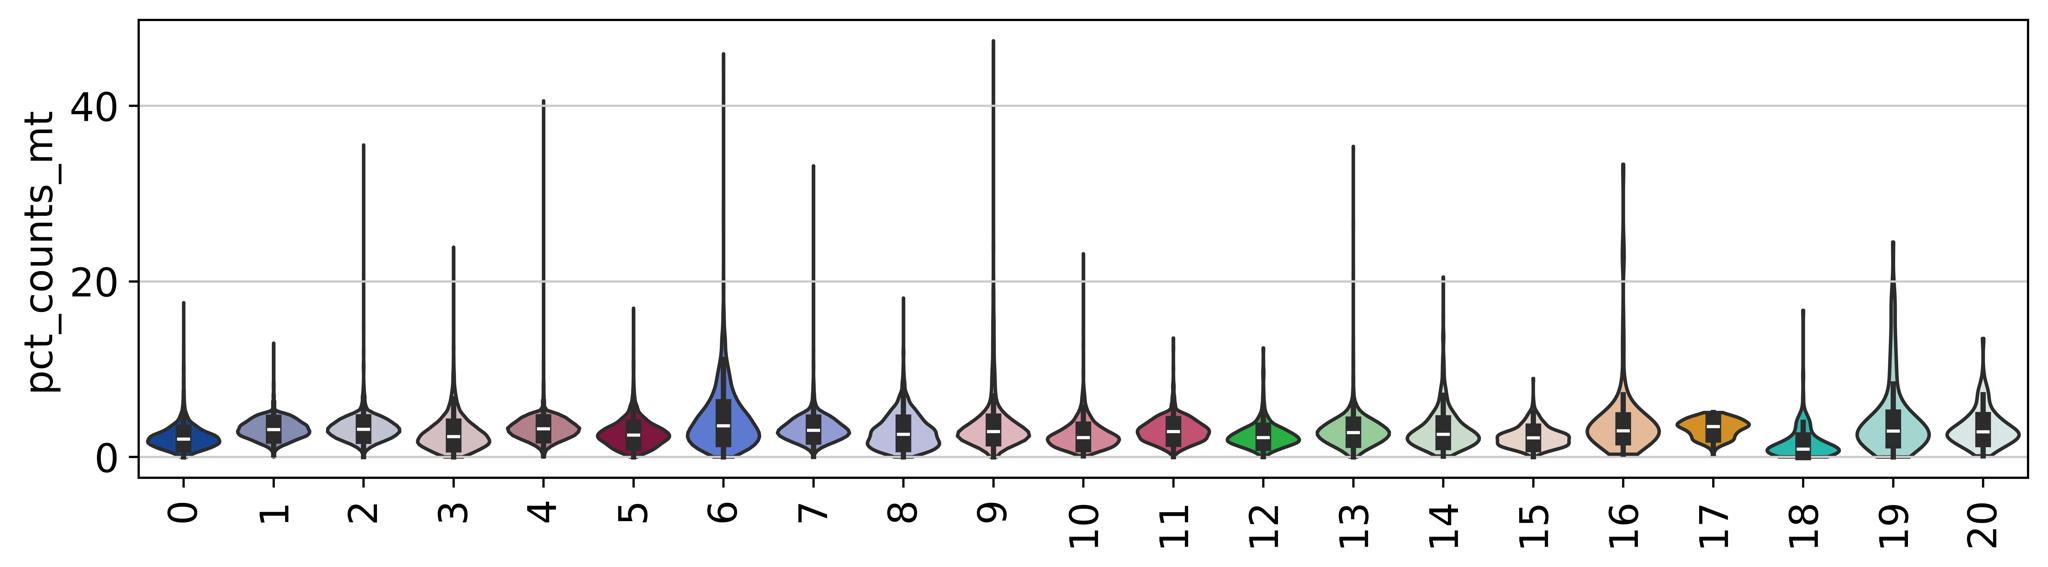

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


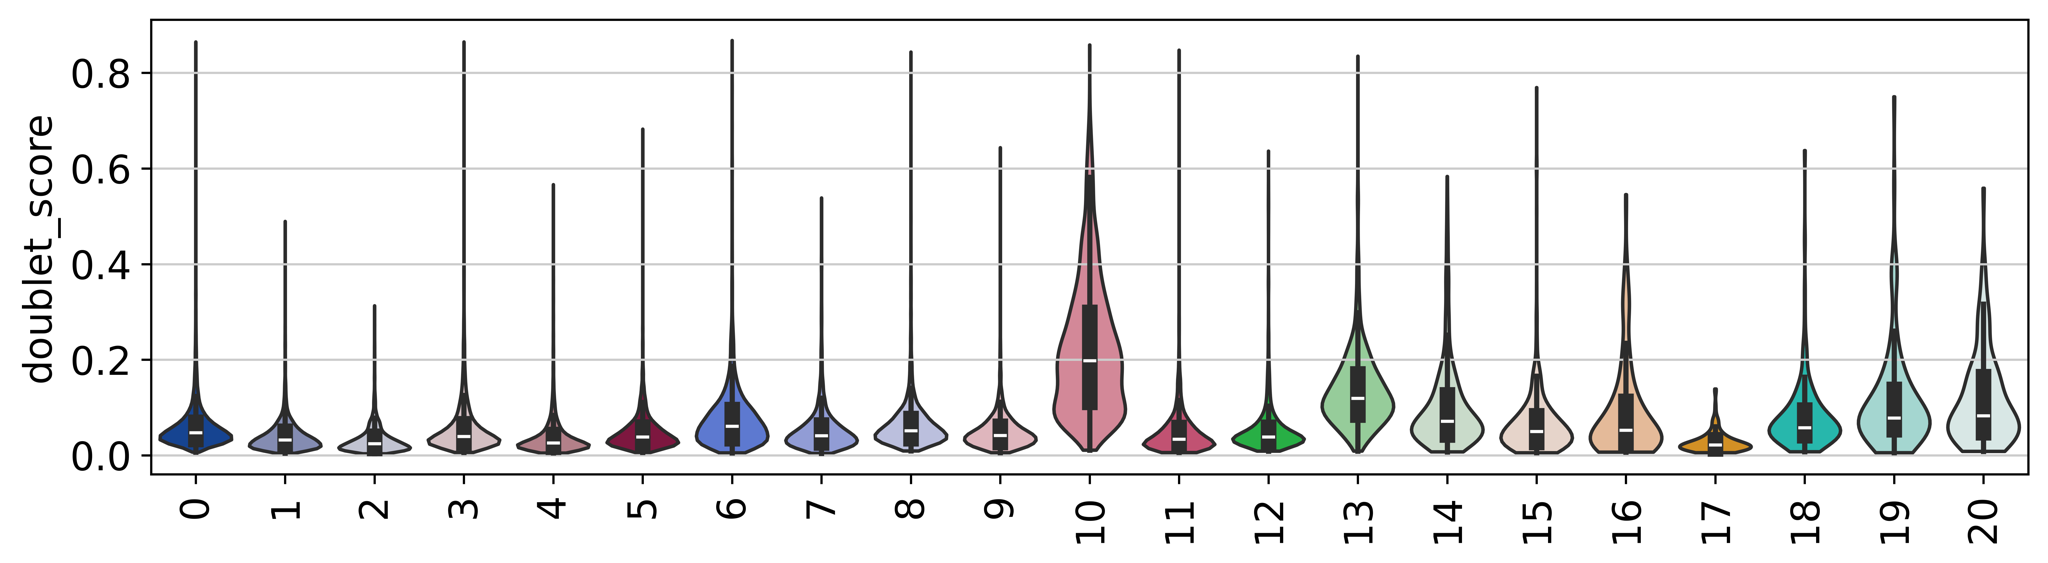

In [49]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')

cur_clusters = 'leiden_1'

sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby=cur_clusters, multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby=cur_clusters, multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby=cur_clusters, multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby=cur_clusters, multi_panel=False, rotation=90)

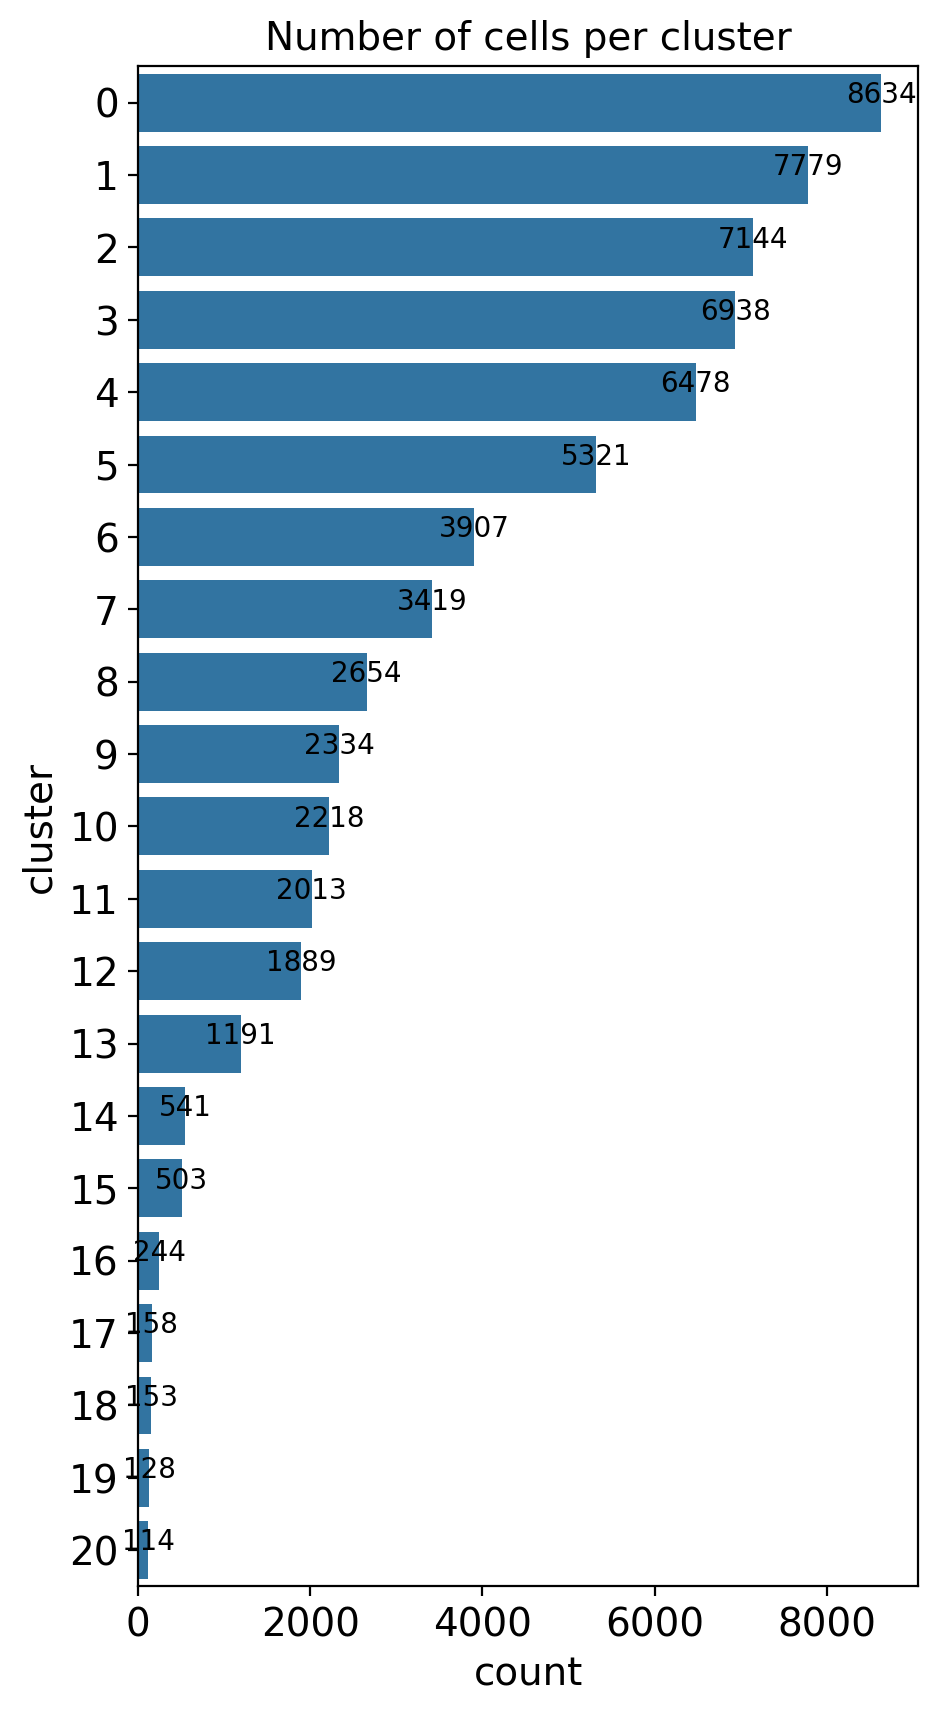

In [50]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,10), facecolor='white')

cur_clusters = 'leiden_1'

cluster_counts = adata.obs[cur_clusters].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

sns.barplot(
    data = cluster_counts, x='count', y='cluster'
)

# Add count labels on top of the bars
for index, row in cluster_counts.iterrows():
    plt.text(y=index, x=row['count'], s=row['count'], ha='center', fontsize=10)

plt.title('Number of cells per cluster')
plt.grid(False)
plt.savefig(
    "{}/barplot_{}_{}.pdf".format(fig_dir, cur_celltype, cur_clusters), 
    format="pdf", bbox_inches="tight"
)
plt.show()

## Evaluate CellANOVA performance

In [6]:
# write the CellANOVA intermediate file
adata_cn = sc.read_h5ad("{}/{}_CellANOVA_HVGs.h5ad".format(data_dir, cur_celltype))

In [21]:
# no idea how long this will take to run
res = cnova.utils.calc_oobNN(
    adata_cn, 
    batch_key='Replicate', 
    condition_key='dataset'
)

df = res.obsm['knn_prop']
df['condition'] = res.obs['dataset']
df = df.reset_index()
df = pd.melt(df, id_vars=['barcode', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'barcode': 'obs_name'})



/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  knn_labels = labels_train[knn_indices[i,]]
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The d

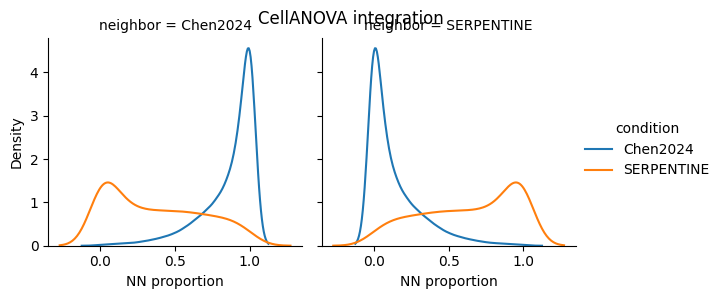

In [22]:

g = sns.FacetGrid(df, col='neighbor', hue='condition')
g.map(sns.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('CellANOVA integration')
sns.set_style('white')
plt.show()